In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d

import sys
sys.path.append('/Users/audreyburggraf/Desktop/THESIS/Functions')
from functions import sigma_fov, find_star_mass, astrometric_signature

from unit_conversion_functions import earth_to_jupiter_mass, days_to_years

### data_wo_cross
SELECT TOP 1000000000 source_id, parallax, bp_rp, phot_g_mean_mag \
FROM gaiadr3.gaia_source \
WHERE parallax > 10

### data_w_cross
SELECT TOP 500000 gaia.source_id, gaia.parallax, gaia.bp_rp, gaia.phot_g_mean_mag, tmass.* \
FROM gaiadr3.gaia_source AS gaia \
JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS xmatch USING (source_id) \
JOIN gaiadr3.tmass_psc_xsc_join AS xjoin USING (clean_tmass_psc_xsc_oid) \
JOIN gaiadr1.tmass_original_valid AS tmass ON \
   xjoin.original_psc_source_id = tmass.designation \
WHERE parallax > 10 

In [2]:
directory = '/Users/audreyburggraf/Desktop/THESIS/Gaia Data Files/'

data_wo_cross = pd.read_csv(directory + 'data_wo_cross.csv')
data_w_cross = pd.read_csv(directory + 'data_w_cross.csv')

print('data_wo_cross length:', len(data_wo_cross))
print('data_w_cross length:', len(data_w_cross))

df = data_w_cross

data_wo_cross length: 156494
data_w_cross length: 300808


In [3]:
df.columns

Index(['source_id', 'parallax', 'bp_rp', 'phot_g_mean_mag', 'ph_qual',
       'tmass_oid', 'designation', 'ra', 'dec', 'err_maj', 'err_min',
       'err_ang', 'j_m', 'j_msigcom', 'h_m', 'h_msigcom', 'ks_m', 'ks_msigcom',
       'ext_key', 'j_date'],
      dtype='object')

In [4]:
df

source_id    parallax     bp_rp  phot_g_mean_mag ph_qual  \
0       1769202380476257280   10.000008  2.731872        15.390248     AAA   
1        518180210764160512   10.000029  2.025819        13.608475     AAA   
2        473881441333817984   10.000032  0.880858         9.267752     AAA   
3       2629631149026173952   10.000042  2.855918        16.122866     AAA   
4       6473748546781525888   10.000051  3.844704        18.146105     AAA   
...                     ...         ...       ...              ...     ...   
300803  6553614253923452800  304.135369  2.098285         6.522032     DDC   
300804  5164707970261890560  310.577293  1.140298         3.465752     DDD   
300805  4075141768785646848  336.026602  2.834036         9.126414     AAA   
300806   762815470562110464  392.752945  2.215609         6.551172     DDD   
300807  3864972938605115520  415.179416  4.184836        11.038391     AAA   

        tmass_oid       designation          ra        dec  err_maj  err_min  \
0       337631338  21475149+1449319  326.964547  14.825546     0.07     0.06   
1       460419620  02003742+6515593   30.155939  65.266487     0.07     0.06   
2       452686025  04025950+6043380   60.747953  60.727234     0.07     0.06   
3       287550147  22281253-0145408  337.052222  -1.761338     0.07     0.06   
4        81249757  20131287-5246558  303.303650 -52.782173     0.06     0.06   
...           ...               ...         ...        ...      ...      ...   
300803  153595082  23055131-3551130  346.463814 -35.853634     0.30     0.29   
300804  262118694  03325591-0927298   53.232961  -9.458295     0.29     0.29   
300805  207004321  18494929-2350101  282.455404 -23.836149     0.06     0.06   
300806  395683145  11032027+3558203  165.834471  35.972317     0.47     0.30   
300807  314462619  10562886+0700527  164.120270   7.014658     0.11     0.09   

        err_ang     j_m  j_msigcom     h_m  h_msigcom    ks_m  ks_msigcom  \
0            90  12.485      0.023  11.918      0.020  11.680       0.023   
1             0  11.291      0.023  10.671      0.021  10.470       0.020   
2             0   8.187      0.041   7.833      0.034   7.757       0.024   
3            90  12.909      0.027  12.472      0.029  12.143       0.026   
4            90  14.734      0.034  14.150      0.040  13.853       0.048   
...         ...     ...        ...     ...        ...     ...         ...   
300803        0   4.338      0.258   3.608      0.230   3.465       0.200   
300804        0   2.228      0.298   1.880      0.276   1.776       0.286   
300805       90   6.222      0.018   5.655      0.034   5.370       0.016   
300806        0   4.320      0.282   3.722      0.224   3.501       0.352   
300807       90   7.085      0.024   6.482      0.042   6.084       0.017   

        ext_key        j_date  
0           NaN  2.450700e+06  
1           NaN  2.451183e+06  
2           NaN  2.451591e+06  
3           NaN  2.451094e+06  
4           NaN  2.451440e+06  
...         ...           ...  
300803      NaN  2.451060e+06  
300804      NaN  2.451144e+06  
300805      NaN  2.450952e+06  
300806      NaN  2.450895e+06  
300807      NaN  2.451605e+06  

[300808 rows x 20 columns]

### Gaia G absolute magnitude ($M_G$)

$M_G = G + 5 + 5\log_{10}(\varpi/1000)$
- $G$ is from Gaia in units of mag
- $\varpi$ is parallax in units of mas
- Equation from Gaia Data Release 2 - Observational Hertzspring-Russel diagrams page 3 (https://www.aanda.org/articles/aa/pdf/2018/08/aa32843-18.pdf)

In [5]:
df["M_G"] = df.phot_g_mean_mag + 5 + 5*np.log10(df.parallax/1000)
df["M_ks"] = df.ks_m + 5 + 5*np.log10(df.parallax/1000)

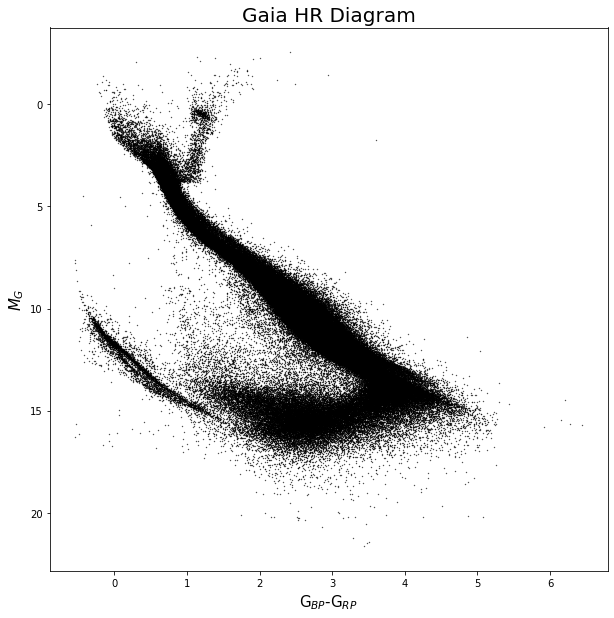

In [6]:
fig, ax = plt.subplots(figsize=(10,10))

plt.scatter(df.bp_rp, 
            df.M_G, 
            s=0.1,
            color='black')


ax.set_xlabel('G$_{BP}$-G$_{RP}$', fontsize=15)
ax.set_ylabel('$M_G$', fontsize=15)
ax.set_title('Gaia HR Diagram', fontsize=20)
ax.invert_yaxis() 

# $\sigma_{\text{fov}}$ 
- along-scan accuracy per field of view crossing as a function of G magnitude 

## Interpolation 
- Returns 32.4 if x < 6
- interpolates from (6,20)
- Returns Nan if x >20

In [7]:
# G = range(6,21)

# # these values are in microarcseconds
# sigma_fov_interp = [34.2, 34.2, 34.2, 34.2, 34.2, 34.2, 34.2, 41.6, 56.1, 82.0, 125.7, 198.3, 320.6, 538.4, 996.5]

# interp_sigma = interp1d(G, sigma_fov_interp, bounds_error=False, fill_value=(34.2, np.nan))

# plt.scatter(G, sigma_fov_interp)
# xnew = 21
# plt.scatter(xnew, interp_sigma(xnew))

# plt.hist(df.phot_g_mean_mag, bins=50)


# run function
sigma_fov(df)

### Stellar mass : $M_*$

Recreating figure 9 

### $\log_{10}\left(\frac{M_*}{M_\odot}\right)=\sum_{i=0}^{5}a_i(M_{k_S}-7.5)^i$

### $\log_{10}x=y\longrightarrow 10^y=x$

In [8]:
# def find_mass(M_ks):
#     a_i = [-0.642, -0.208, -8.43e-4, 7.87e-3, 1.42e-4, -2.13e-4]
    
#     sum = 0 
    
#     for i in range(0,6):
#         sum += a_i[i]*(M_ks-7.5)**i
       
#     m_star = 10**sum
    
#     return(m_star) # this value is in solar masses 

In [9]:
# f = np.poly1d([-0.642, -0.208, -8.43e-4, 7.87e-3, 1.42e-4, -2.13e-4][::-1])

In [10]:
test_M_ks = np.arange(4,11.2,0.1)
test_stellar_mass = find_star_mass(test_M_ks)

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


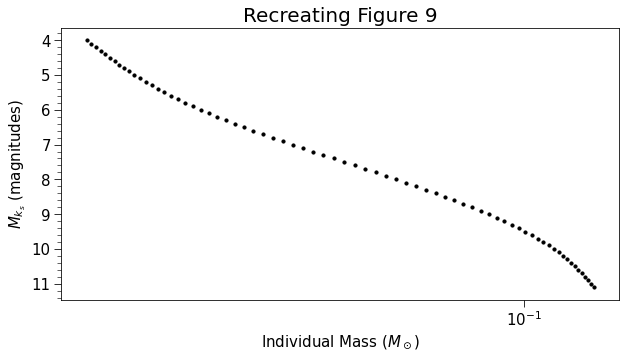

In [11]:
fig, ax = plt.subplots(figsize=(10,5))

plt.scatter(test_stellar_mass, 
            test_M_ks, 
            s=10,
            color='black')


ax.set_xlabel('Individual Mass ($M_\odot$)', fontsize=15)
ax.set_ylabel('$M_{k_s}$ (magnitudes)', fontsize=15)
ax.set_title('Recreating Figure 9', fontsize=20)

plt.xscale('log')

ax.invert_xaxis() 
ax.invert_yaxis() 

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

# ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7, labelsize = 15)
ax.tick_params(which='minor', length=4)

In [12]:
df = df[(4 < df.M_ks) & (df.M_ks < 11)].reset_index(drop=True)
df

source_id    parallax     bp_rp  phot_g_mean_mag ph_qual  \
0       1769202380476257280   10.000008  2.731872        15.390248     AAA   
1        518180210764160512   10.000029  2.025819        13.608475     AAA   
2       2629631149026173952   10.000042  2.855918        16.122866     AAA   
3       6473748546781525888   10.000051  3.844704        18.146105     AAA   
4         71475475647268736   10.000066  2.649735        15.506643     AAA   
...                     ...         ...       ...              ...     ...   
258491  6553614253923452800  304.135369  2.098285         6.522032     DDC   
258492  5164707970261890560  310.577293  1.140298         3.465752     DDD   
258493  4075141768785646848  336.026602  2.834036         9.126414     AAA   
258494   762815470562110464  392.752945  2.215609         6.551172     DDD   
258495  3864972938605115520  415.179416  4.184836        11.038391     AAA   

        tmass_oid       designation          ra        dec  err_maj  ...  \
0       337631338  21475149+1449319  326.964547  14.825546     0.07  ...   
1       460419620  02003742+6515593   30.155939  65.266487     0.07  ...   
2       287550147  22281253-0145408  337.052222  -1.761338     0.07  ...   
3        81249757  20131287-5246558  303.303650 -52.782173     0.06  ...   
4       375554729  03401379+2821032   55.057460  28.350889     0.07  ...   
...           ...               ...         ...        ...      ...  ...   
258491  153595082  23055131-3551130  346.463814 -35.853634     0.30  ...   
258492  262118694  03325591-0927298   53.232961  -9.458295     0.29  ...   
258493  207004321  18494929-2350101  282.455404 -23.836149     0.06  ...   
258494  395683145  11032027+3558203  165.834471  35.972317     0.47  ...   
258495  314462619  10562886+0700527  164.120270   7.014658     0.11  ...   

        j_msigcom     h_m  h_msigcom    ks_m  ks_msigcom  ext_key  \
0           0.023  11.918      0.020  11.680       0.023      NaN   
1           0.023  10.671      0.021  10.470       0.020      NaN   
2           0.027  12.472      0.029  12.143       0.026      NaN   
3           0.034  14.150      0.040  13.853       0.048      NaN   
4           0.023  12.105      0.027  11.874       0.021      NaN   
...           ...     ...        ...     ...         ...      ...   
258491      0.258   3.608      0.230   3.465       0.200      NaN   
258492      0.298   1.880      0.276   1.776       0.286      NaN   
258493      0.018   5.655      0.034   5.370       0.016      NaN   
258494      0.282   3.722      0.224   3.501       0.352      NaN   
258495      0.024   6.482      0.042   6.084       0.017      NaN   

              j_date        M_G      M_ks   sigma_fov  
0       2.450700e+06  10.390250  6.680002   99.053838  
1       2.451183e+06   8.608481  5.470006   50.422888  
2       2.451094e+06  11.122875  7.143009  134.620072  
3       2.451440e+06  13.146116  8.853011  352.421669  
4       2.451494e+06  10.506657  6.874014  104.140299  
...              ...        ...       ...         ...  
258491  2.451060e+06   8.937367  5.880335   34.200000  
258492  2.451144e+06   5.926601  4.236849   34.200000  
258493  2.450952e+06  11.758282  8.001868   34.200000  
258494  2.450895e+06   9.521769  6.471597   34.200000  
258495  2.451605e+06  14.129570  9.175179   34.200000  

[258496 rows x 23 columns]

### Interpolate the plot 

In [13]:
# interp_mass = interp1d(test_M_ks, test_stellar_mass, bounds_error=False, fill_value=(np.nan, np.nan))

# print("x min: ", test_M_ks.min())
# print("x max: ", test_M_ks.max())

$M_{k_s} = m_{k_s} + 5 + 5\log_{10}(\varpi/1000)$

In [14]:
# print("m_k min: ", df.ks_m.min())
# print("m_k max: ", df.ks_m.max())

In [15]:
df["stellar_mass"] =  find_star_mass(df.M_ks)

In [16]:
print("ks_m min: ", df.ks_m.min())
print("ks_m max: ", df.ks_m.max())

ks_m min:  1.776
ks_m max:  15.974


In [17]:
print("parallax min: ", df.parallax.min())
print("parallax max: ", df.parallax.max())

parallax min:  10.000008327879812
parallax max:  415.17941567802137


In [18]:
print("stellar_mass min: ", df.stellar_mass.min())
print("stellar_mass max: ", df.stellar_mass.max())

stellar_mass min:  0.07354374574513708
stellar_mass max:  0.7437377220978479


/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


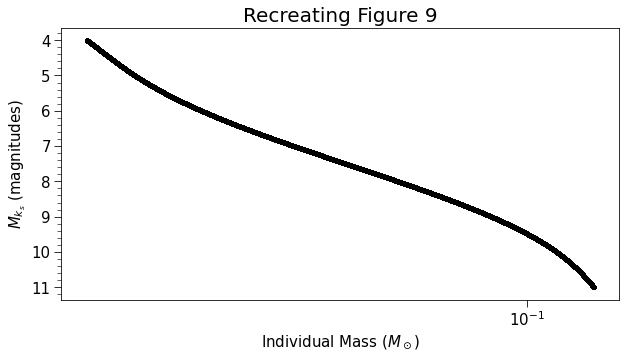

In [19]:
fig, ax = plt.subplots(figsize=(10,5))

plt.scatter(df.stellar_mass, 
            df.M_ks, 
            s=10,
            color='black')


ax.set_xlabel('Individual Mass ($M_\odot$)', fontsize=15)
ax.set_ylabel('$M_{k_s}$ (magnitudes)', fontsize=15)
ax.set_title('Recreating Figure 9', fontsize=20)

plt.xscale('log')

ax.invert_xaxis() 
ax.invert_yaxis() 

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

# ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7, labelsize = 15)
ax.tick_params(which='minor', length=4)

### Setting some parameters

In [31]:
# planet mass is equatl to 1.5 jupiter masses
df["planet_mass"] = 1.5 # jupiter masses 

# find distance in pc from parallax in mas using d=1/parallax
df["distance"] = 1000/(df.parallax)

# setting Period equal to 1 year 
df["P"] = 1

### semi-major axis $a$

### $a_p  =\left(P^2\cdot m_*\right)^{1/3}$
- units of AU

In [32]:
df["a"] = (df.P**2*df.stellar_mass)**(1/3)

### Astrometric signature $\alpha$

## $\alpha = \left(\frac{m_p}{m_*}\right)\left(\frac{a_p}{\text{1 AU}}\right)\left(\frac{d}{\text{1 pc}}\right)^{-1}$ arcsec

## $\alpha = \left(\frac{m_p}{m_*}\right)\left(\frac{m_*^{1/3}P^{2/3}}{\text{1 years}}\right)\left(\frac{d}{\text{1 pc}}\right)^{-1}$ arcsec

In [36]:
df["alpha"]=((df.planet_mass)/df.stellar_mass)*(df.a)*(df.distance)**(-1)

In [37]:
##MAKE THIS INTO A FUNCTION


# check to make sure that this function works for HD 80606
# expecting for it to be around 30 microarcseconds 

HD80606_period = days_to_years(111.43670)      # [years] (converted from days)
HD80606_mstar = 1.0471375340700000  # [M solar]


HD80606_mplanet = earth_to_jupiter_mass(1392) # [M_Jupiter] (converted from earth masses)
HD80606_d = 66.4711 # [pc]

HD80606_alpha = astrometric_signature(HD80606_mplanet, HD80606_mstar, HD80606_period, HD80606_d) # [uas]

print ("The signal is", HD80606_alpha, "uas")

The signal is 27.636322103278747 uas
